In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from scipy.spatial.distance import pdist
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
from minisom import MiniSom
from py_pcha import PCHA
import tqdm

In [7]:
# hr_data = pd.read_csv('data/HR_data.csv')
hr_data = pd.read_csv('data\dataset\HR_data_2.csv')
# print(hr_data.columns)
RANDOM = 21

In [8]:
# Helper functions 
def gap_statistic(range_n_clusters, numpy_data):
    def wk(labels, data, k):
        clusters = {i: data[labels == i] for i in range(k)}
        centroids = np.array([np.mean(clusters[i], axis=0) for i in range(k)])
        w_k = 0
        for l in range(k):
            cluster = clusters[l]
            N_l = cluster.shape[0]
            if N_l == 0: continue
            dist = np.linalg.norm(cluster - centroids[l], axis=1)
            D_l = N_l * np.sum(dist**2)
            w_k += D_l / (2 * N_l)
        return w_k

    sim_data_sets = [np.random.uniform(np.min(numpy_data, axis=0), 
                                       np.max(numpy_data, axis=0), 
                                       size=numpy_data.shape) 
                     for _ in range(20)]  

    w_ks, u_ks = [], []
    for k in tqdm.tqdm(range_n_clusters):
        labels = KMeans(n_clusters=k, random_state=RANDOM).fit_predict(numpy_data)
        w_ks.append(wk(labels, numpy_data, k))

        sim_wks = []
        for sim in sim_data_sets:
            sim_labels = KMeans(n_clusters=k, random_state=RANDOM).fit_predict(sim)
            sim_wks.append(wk(sim_labels, sim, k))
        u_ks.append(sim_wks)  
    u_ks = np.array(u_ks)
    w_ks = np.array(w_ks)  # Convert to numpy array

    g_k = np.log(u_ks.mean(axis=1)) - np.log(w_ks)  # Compute gap statistic
    return g_k, u_ks, w_ks  # Return w_ks as well

In [9]:
"""
NOTE: D11 winter, and D12 and D13 were completed in the fall 
D131 and D133 were completed in the morning and D132 and D134 were collected in the evening
"Frustrated" is (Only asked in the task phase) On a scale from 0-10, where 0 is not difficult at all and 10 is extremely difficult, how difficult did you find the task?
there are 312 rows = 26 participants * 4 rounds * 3 phases
"""

# Special columns:
# Round,Phase,Individual,Puzzler,original_ID,raw_data_path,Team_ID,Frustrated,Cohort,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined
# Categorical/Ordinal categorical columns: Round,Phase,Individual,Puzzler,original_ID,raw_data_path,Team_ID,Cohort,frustrated,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined

# Find missing values
print("There are na values in the data: ", hr_data.isna().sum().sum())
print("The missing values are in the following columns: ", hr_data.isna().sum()[hr_data.isna().sum() > 0].index.tolist())
print("The missing values are in the following rows: ", hr_data[hr_data.isna().sum(axis=1) > 0].index.tolist())

# Replace the missing values with the mode of the column
for col in hr_data.columns:
    if hr_data[col].isna().sum() > 0:
        if hr_data[col].dtype == 'object' or hr_data[col].dtype.name == 'category':
            hr_data[col] = hr_data[col].fillna(hr_data[col].mode()[0])
        else:
            hr_data[col] = hr_data[col].fillna(int(hr_data[col].mode()[0]))

# Get the last element of the string in the column "Phase" and "Round" and make it int
hr_data['Round'] = hr_data['Round'].apply(lambda x: int(x.split('_')[-1]))
hr_data['Phase'] = hr_data['Phase'].apply(lambda x: int(x[-1]))

# One hot encoding for the string columns
hr_data_with_dummies = pd.get_dummies(hr_data, columns=['Cohort', 'Team_ID', 'Puzzler'], dtype=np.int8)
# hr_data_with_dummies.info()

# Keep all columns except the first column (participant ID) the raw data path column
hr_data_with_dummies = hr_data_with_dummies.drop('raw_data_path', axis=1)
hr_data_with_dummies = hr_data_with_dummies.iloc[:, 1:]
# hr_data_with_dummies.info()

# Check missing values
print("After there are na values in the data: ", hr_data.isna().sum().sum())
print("After the missing values are in the following columns: ", hr_data.isna().sum()[hr_data.isna().sum() > 0].index.tolist())
print("After the missing values are in the following rows: ", hr_data[hr_data.isna().sum(axis=1) > 0].index.tolist())

# numpy_data = hr_data_with_dummies.to_numpy()




There are na values in the data:  9
The missing values are in the following columns:  ['EDA_TD_P_RT', 'EDA_TD_P_ReT', 'inspired', 'attentive', 'afraid', 'active', 'determined']
The missing values are in the following rows:  [104, 120, 122, 125, 272]
After there are na values in the data:  0
After the missing values are in the following columns:  []
After the missing values are in the following rows:  []


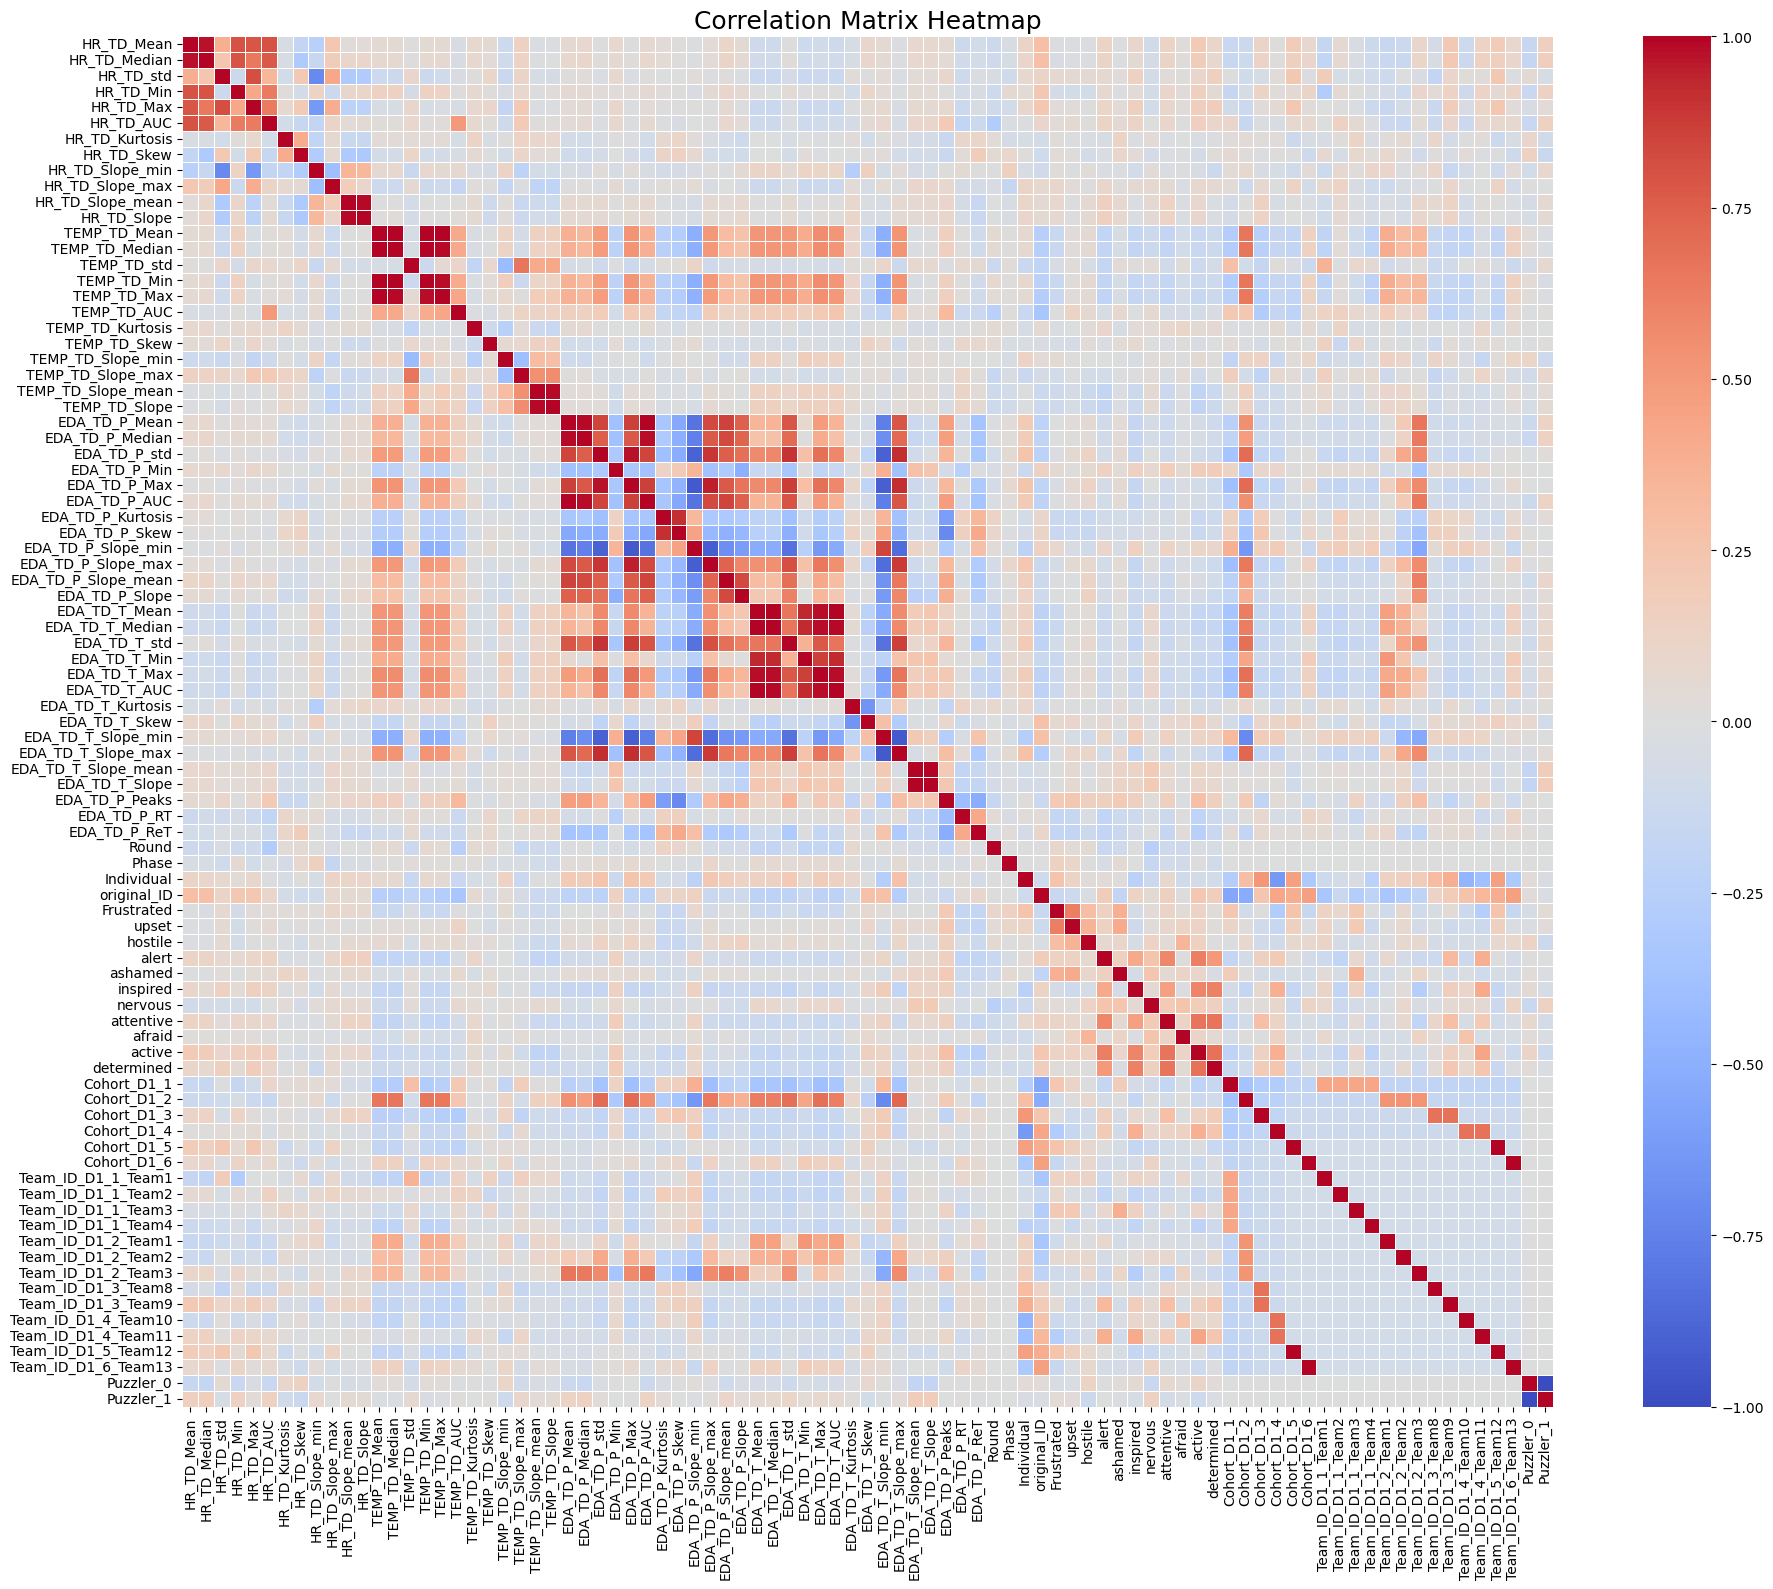

Found 90 feature pairs with correlation > 0.7

Top 10 highest correlations:
Puzzler_0 and Puzzler_1: -1.000
Cohort_D1_5 and Team_ID_D1_5_Team12: 1.000
Cohort_D1_6 and Team_ID_D1_6_Team13: 1.000
TEMP_TD_Mean and TEMP_TD_Median: 1.000
EDA_TD_T_Mean and EDA_TD_T_Median: 0.999
EDA_TD_P_Mean and EDA_TD_P_AUC: 0.999
EDA_TD_T_Slope_mean and EDA_TD_T_Slope: 0.996
TEMP_TD_Mean and TEMP_TD_Min: 0.996
TEMP_TD_Median and TEMP_TD_Min: 0.995
EDA_TD_T_Mean and EDA_TD_T_AUC: 0.994


In [10]:
import seaborn as sns

# Calculate correlation matrix
corr_matrix = hr_data_with_dummies.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(20, 16))
# Using seaborn for better visualization
heatmap = sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', 
                     vmin=-1, vmax=1, center=0, square=True, linewidths=0.5)
plt.title('Correlation Matrix Heatmap', fontsize=18)
plt.tight_layout()
plt.show()

# Find and display highly correlated features
threshold = 0.7
high_corr = corr_matrix.where(np.abs(corr_matrix) > threshold)

# Get pairs of features with high correlation (excluding self-correlations)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Display top high correlations
if high_corr_pairs:
    print(f"Found {len(high_corr_pairs)} feature pairs with correlation > {threshold}")
    print("\nTop 10 highest correlations:")
    for col1, col2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:10]:
        print(f"{col1} and {col2}: {corr:.3f}")
else:
    print(f"No feature pairs with correlation > {threshold}")

# Create numpy_data from hr_data_with_dummies for subsequent cells
numpy_data = hr_data_with_dummies.to_numpy()

In [ ]:
# Normalize the data
numpy_data = StandardScaler().fit_transform(numpy_data)

#### Silhouette analysis ####
cluster_range = range(2, 61)
results = []
s_scores = []
for n_clusters in tqdm.tqdm(cluster_range):
    clusterer = KMeans(n_clusters=n_clusters, random_state=RANDOM)
    cluster_labels = clusterer.fit_predict(numpy_data)
    silhouette_avg = silhouette_score(numpy_data, cluster_labels)
    silhouette_vals = silhouette_samples(numpy_data, cluster_labels)
    
    # Store results
    results.append({
        'n_clusters': n_clusters,
        'score': silhouette_avg,
        'labels': cluster_labels,
        'silhouette_vals': silhouette_vals,
        'clusterer': clusterer  # Optional: store the model if needed later
    })
    s_scores.append(silhouette_avg)

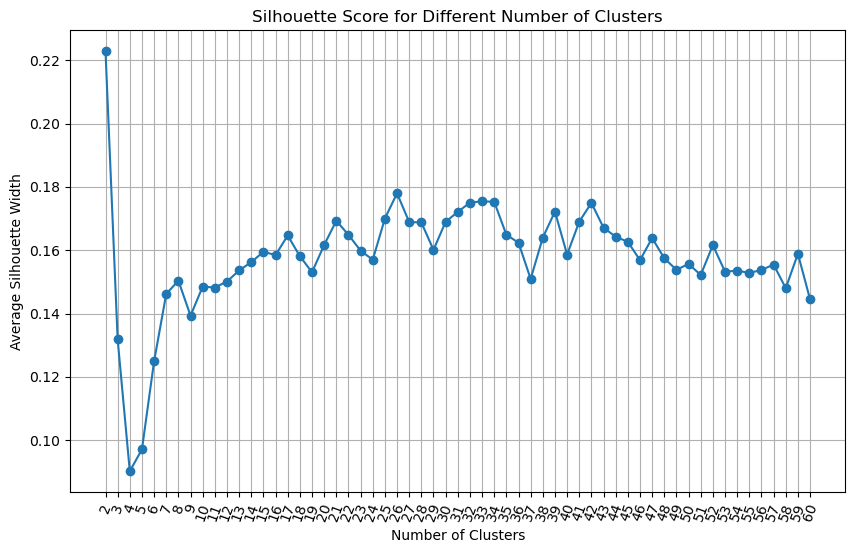

In [28]:
# Plot 1: Silhouette score vs number of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, s_scores, marker='o')
plt.xticks(cluster_range, rotation=70)
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Width')
plt.title('Silhouette Score for Different Number of Clusters')
plt.grid(True)
plt.show()


# Find the top 4 cluster configurations
top_indices = sorted(range(len(s_scores)), key=lambda i: s_scores[i], reverse=True)[:4]
top_clusters = [results[i] for i in top_indices]

In [36]:
# Choose K∗ with the maximum average silhouette
#best_idx = s_scores.index(max(s_scores))
# Define restricted range and corresponding indices
restricted_range = list(range(2, 31))
restricted_indices = [i for i, k in enumerate(cluster_range) if k in restricted_range]
best_idx = max(restricted_indices, key=lambda i: s_scores[i])

print(f"Choice 1, using the maximum average silhouette: {cluster_range[best_idx]} with a value of {max(s_scores)}")

# Choose the smallest K such that all clusters have average s(i) > overall average
mean_silhouette = np.mean(s_scores)
print("Choice 2, using the rule that all clusters have average s(i) > overall average: ", 
      cluster_range[next(i for i, score in enumerate(s_scores) if score > mean_silhouette)])

Choice 1, using the maximum average silhouette: 2 with a value of 0.2228452583960221
Choice 2, using the rule that all clusters have average s(i) > overall average:  2


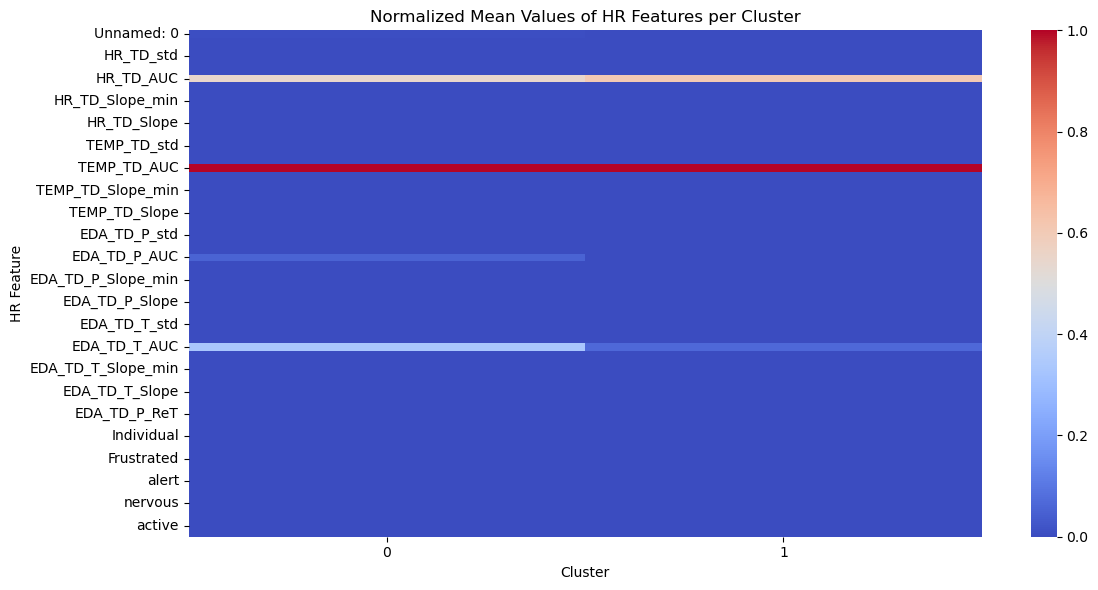

In [37]:
best_k = cluster_range[best_idx]
best_result = results[best_idx]
hr_data['cluster'] = best_result['labels']

from sklearn.preprocessing import MinMaxScaler

# Group mean by cluster
cluster_summary = hr_data.groupby('cluster').mean(numeric_only=True)

# Normalize across each feature (row-wise)
scaler = MinMaxScaler()
normalized = pd.DataFrame(
    scaler.fit_transform(cluster_summary.T),
    index=cluster_summary.columns,
    columns=cluster_summary.index
).T  # transpose back

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(normalized.T, cmap="coolwarm")
plt.title("Normalized Mean Values of HR Features per Cluster")
plt.xlabel("Cluster")
plt.ylabel("HR Feature")
plt.tight_layout()
plt.show()

In [ ]:
hr_data['cluster'].value_counts().sort_index()
pd.crosstab(hr_data['cluster'], hr_data['Phase'], normalize='index')

Phase,1,2,3
cluster,,,
0,0.321429,0.357143,0.321429
1,0.335938,0.328125,0.335938


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import f_oneway

# Step 1: Normalize numeric columns (excluding IDs and cluster labels)
exclude_cols = [
    'cluster', 'original_ID', 'Unnamed: 0', 'Round', 'Phase', 'Individual',
    'Puzzler', 'Frustrated', 'Cohort', 'upset', 'hostile', 'alert',
    'ashamed', 'inspired', 'nervous', 'attentive', 'afraid',
    'active', 'determined'
]
numeric_cols = hr_data.select_dtypes(include='number').columns.drop(exclude_cols, errors='ignore')

scaler = MinMaxScaler()
hr_data_scaled = hr_data.copy()
hr_data_scaled[numeric_cols] = scaler.fit_transform(hr_data_scaled[numeric_cols])

# Step 2: Run one-way ANOVA for each feature across clusters
anova_results = {}
for col in numeric_cols:
    cluster_groups = [group[col].dropna().values for _, group in hr_data_scaled.groupby('cluster')]
    stat, p_value = f_oneway(*cluster_groups)
    anova_results[col] = p_value

# Step 3: Create sorted Series of p-values and filter significant features
anova_pvals = pd.Series(anova_results).sort_values()
significant_features = anova_pvals[anova_pvals < 0.05]

# Step 4: Output
print(f"{len(significant_features)} features with significant differences between clusters (p < 0.05):")
print(significant_features)

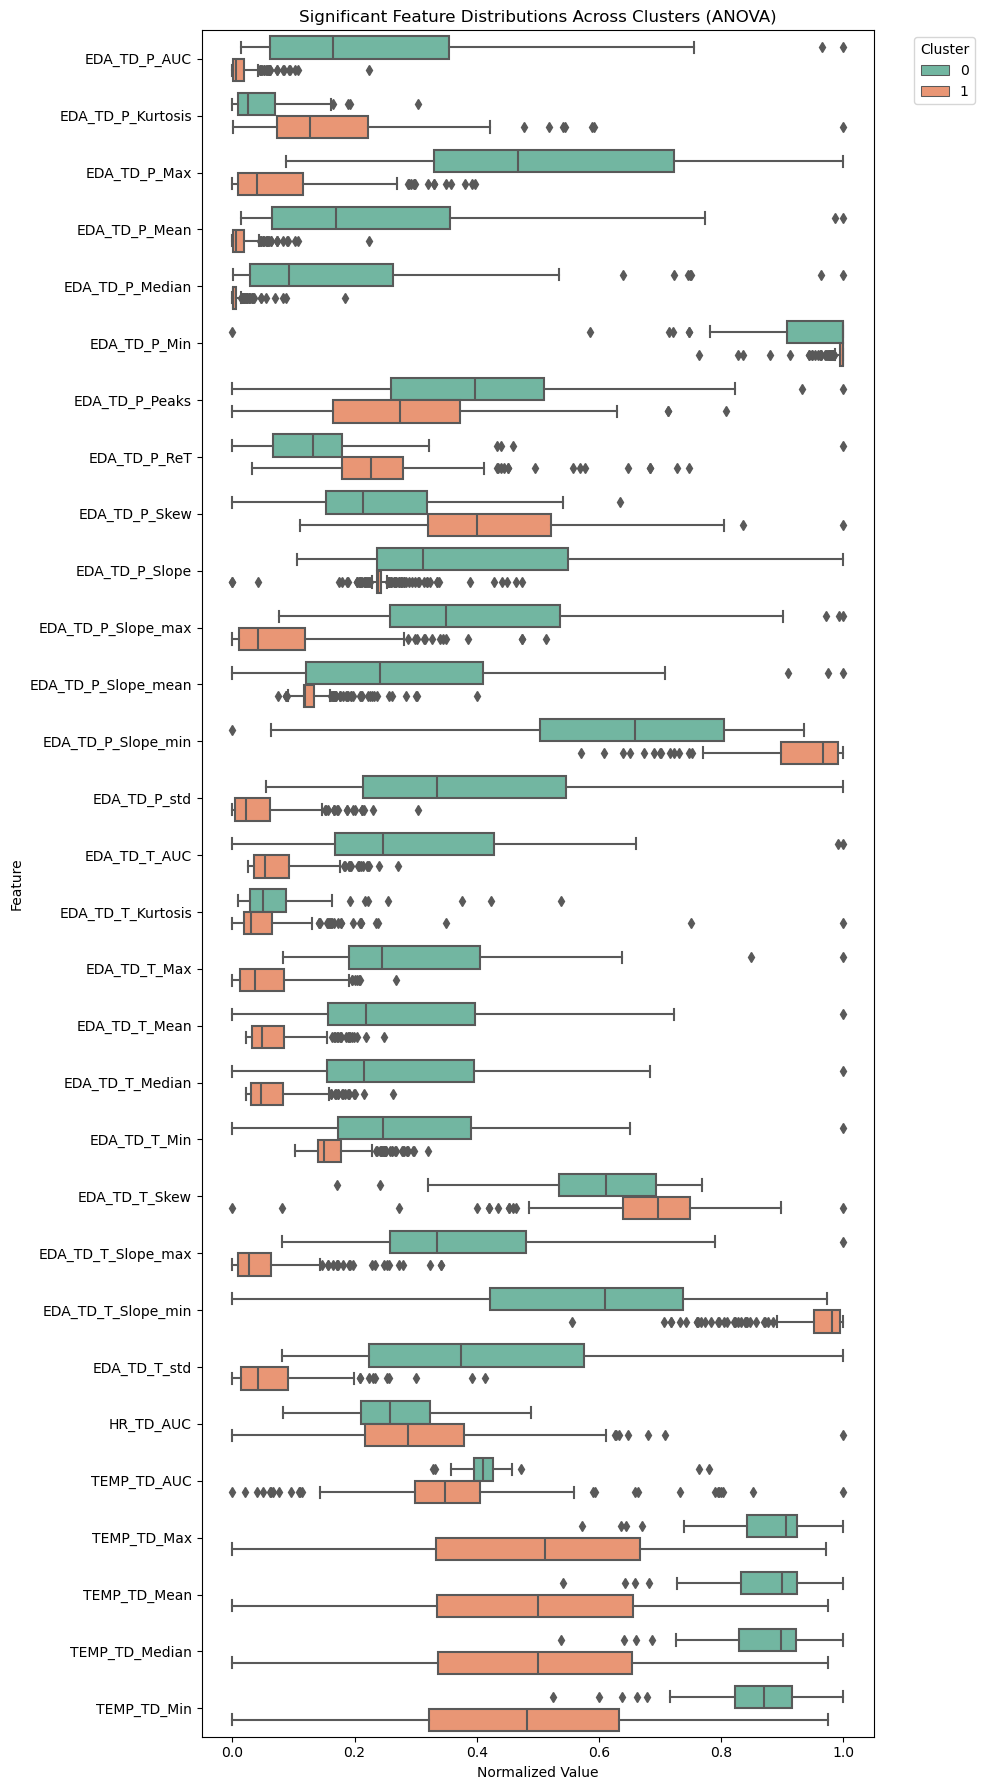

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt for Seaborn
melted = hr_data_scaled[['cluster'] + list(significant_features.index)].melt(
    id_vars='cluster', var_name='Feature', value_name='Value'
)

# Sort features alphabetically
melted['Feature'] = melted['Feature'].astype(str)  # ensure it's a string
melted = melted.sort_values(by='Feature')

# Plot all features on one horizontal plot (sorted)
plt.figure(figsize=(10, len(significant_features) * 0.6))
sns.boxplot(data=melted, x='Value', y='Feature', hue='cluster', orient='h', palette='Set2',
            order=sorted(melted['Feature'].unique()))  # enforce sorted order
plt.title("Significant Feature Distributions Across Clusters (ANOVA)")
plt.xlabel("Normalized Value")
plt.ylabel("Feature")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [70]:
from scipy.stats import chi2_contingency

cat_cols = ['Round', 'Phase', 'Individual', 'Puzzler', 'Cohort']
chi2_results = {}

for col in cat_cols:
    ct = pd.crosstab(hr_data['cluster'], hr_data[col])
    if ct.shape[1] > 1:
        chi2, p, _, _ = chi2_contingency(ct)
        chi2_results[col] = p

chi2_pvals = pd.Series(chi2_results).sort_values()
significant_cat = chi2_pvals[chi2_pvals < 0.05]
print(f"{len(significant_cat)} categorical vars show significant differences (Chi², p < 0.05):")
print(significant_cat)


2 categorical vars show significant differences (Chi², p < 0.05):
Cohort        5.586496e-45
Individual    1.020673e-36
dtype: float64


In [71]:
from scipy.stats import kruskal

ordinal_cols = ['Frustrated', 'upset', 'hostile', 'alert', 'ashamed',
                'inspired', 'nervous', 'attentive', 'afraid', 'active', 'determined']
kruskal_results = {}

for col in ordinal_cols:
    groups = [g[col].dropna() for _, g in hr_data.groupby('cluster')]
    stat, p = kruskal(*groups)
    kruskal_results[col] = p

kruskal_pvals = pd.Series(kruskal_results).sort_values()
significant_ord = kruskal_pvals[kruskal_pvals < 0.05]
print(f"{len(significant_ord)} ordinal vars show significant differences (Kruskal-Wallis, p < 0.05):")
print(significant_ord)

3 ordinal vars show significant differences (Kruskal-Wallis, p < 0.05):
inspired    0.013679
active      0.016052
hostile     0.023193
dtype: float64


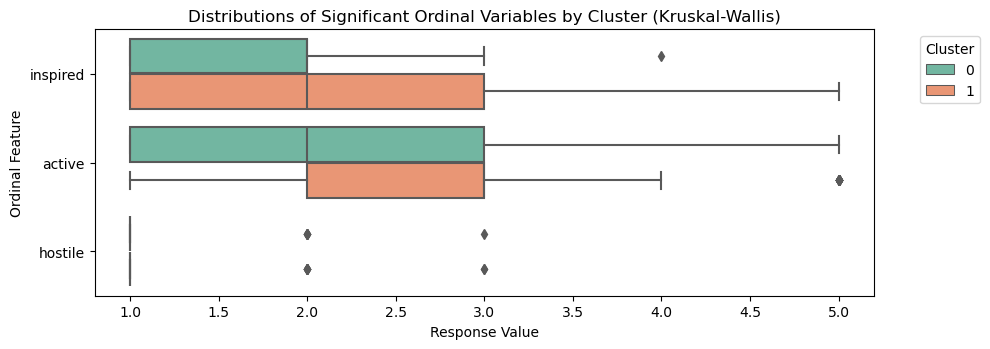

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of significant ordinal features
significant_ordinal = ['inspired', 'active', 'hostile']

# Melt the data for plotting
melted_ordinal = hr_data[['cluster'] + significant_ordinal].melt(
    id_vars='cluster', var_name='Feature', value_name='Value'
)

# Create horizontal boxplots
plt.figure(figsize=(10, len(significant_ordinal) * 1.2))
sns.boxplot(data=melted_ordinal, x='Value', y='Feature', hue='cluster', orient='h', palette='Set2')
plt.title("Distributions of Significant Ordinal Variables by Cluster (Kruskal-Wallis)")
plt.xlabel("Response Value")
plt.ylabel("Ordinal Feature")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [73]:
pd.crosstab(hr_data['cluster'], hr_data['hostile'])


hostile,1.0,2.0,3.0
cluster,,,
0,50,5,1
1,247,7,2
